<a href="https://colab.research.google.com/github/AngeMervaneJdev/ML_AI_1/blob/main/seq2seq1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from PIL import Image

# [Problem 1] Execution of machine translation and code reading

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir /content/gdrive/MyDrive/Colab

In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/Colab/')

In [ ]:
! unzip fra-eng.zip

unzip:  cannot find or open fra-eng.zip, fra-eng.zip.zip or fra-eng.zip.ZIP.


### description

In [ ]:
'''Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
# Summary of the algorithm:
- We start with input sequences from a domain (e.g. English sentences)
    and correspding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    Is uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
# Data download:
English to French sentence pairs.
https://www.manythings.org/anki/fra-eng.zip
Lots of neat sentence pairs datasets can be found at:
https://www.manythings.org/anki/
# References:
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.1078
'''

'Sequence to sequence example in Keras (character-level).\nThis script demonstrates how to implement a basic character-level\nsequence-to-sequence model. We apply it to translating\nshort English sentences into short French sentences,\ncharacter-by-character. Note that it is fairly unusual to\ndo character-level machine translation, as word-level\nmodels are more common in this domain.\n# Summary of the algorithm:\n- We start with input sequences from a domain (e.g. English sentences)\n    and correspding target sequences from another domain\n    (e.g. French sentences).\n- An encoder LSTM turns input sequences to 2 state vectors\n    (we keep the last LSTM state and discard the outputs).\n- A decoder LSTM is trained to turn the target sequences into\n    the same sequence but offset by one timestep in the future,\n    a training process called "teacher forcing" in this context.\n    Is uses as initial state the state vectors from the encoder.\n    Effectively, the decoder learns to ge

### import libs

In [ ]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

### hyperpara settings

In [ ]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '/content/gdrive/MyDrive/Colab/fra-eng/fra.txt'

### preprocessing dataset and create 3 types of input for training model including: ```encoder_input_data```, ```decoder_input_data```, ```decoder_target_data```

In [ ]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
lines = open(data_path).read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 92
Max sequence length for inputs: 15
Max sequence length for outputs: 59


### define and train model

In [ ]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

Epoch 1/100
125/125 [==============================] - 54s 405ms/step - loss: 0.9732 - val_loss: 1.0785
Epoch 2/100
125/125 [==============================] - 49s 394ms/step - loss: 0.9076 - val_loss: 1.0302
Epoch 3/100
125/125 [==============================] - 50s 398ms/step - loss: 0.8590 - val_loss: 0.9558
Epoch 4/100
125/125 [==============================] - 50s 398ms/step - loss: 0.8216 - val_loss: 0.9232
Epoch 5/100
125/125 [==============================] - 50s 399ms/step - loss: 0.7909 - val_loss: 0.8929
Epoch 6/100
125/125 [==============================] - 50s 404ms/step - loss: 0.7624 - val_loss: 0.9304
Epoch 7/100
125/125 [==============================] - 50s 399ms/step - loss: 0.7412 - val_loss: 0.8417
Epoch 8/100
125/125 [==============================] - 49s 395ms/step - loss: 0.7201 - val_loss: 0.8141
Epoch 9/100
125/125 [==============================] - 50s 396ms/step - loss: 0.7043 - val_loss: 0.8004
Epoch 10/100
125/125 [==============================] - 50s 397m

### define inference model: test unknown input seq

In [ ]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

### run the test model and decode result of test sequence to sth readable. fetch previous predicted char to the next LSTM layer to predict the next char until then ```stop_condition```

In [ ]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Sour.

-
Input sentence: Go.
Decoded sentence: Sour.

-
Input sentence: Go.
Decoded sentence: Sour.

-
Input sentence: Hi.
Decoded sentence: Salu .

-
Input sentence: Hi.
Decoded sentence: Salu .

-
Input sentence: Run!
Decoded sentence: Fuie !

-
Input sentence: Run!
Decoded sentence: Fuie !

-
Input sentence: Run!
Decoded sentence: Fuie !

-
Input sentence: Run!
Decoded sentence: Fuie !

-
Input sentence: Run!
Decoded sentence: Fuie !

-
Input sentence: Run!
Decoded sentence: Fuie !

-
Input sentence: Run!
Decoded sentence: Fuie !

-
Input sentence: Run!
Decoded sentence: Fuie !

-
Input sentence: Run.
Decoded sentence: Fule !

-
Input sentence: Run.
Decoded sentence: Fule !

-
Input sentence: Run.
Decoded sentence: Fule !

-
Input sentence: Run.
Decoded sentence: Fule !

-
Input sentence: Run.
Decoded sentence: Fule !

-
Input sentence: Run.
Decoded sentence: Fule !

-
Input sentence: Run.
Decoded sentence: Fule !

-
Input sentence: Run.
Decod

# [Problem 2] Execution of a trained model of image captioning

In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab/image-captioning')
! pwd

/content/gdrive/.shortcut-targets-by-id/1-2czKIaCtFe48Yq3CSquiUlciAPzXzFM/image-captioning


In [ ]:
import os

In [ ]:

os.chdir('coco/PythonAPI/')

os.chdir('../../')
! git clone https://github.com/yunjey/pytorch-tutorial.git
os.chdir('pytorch-tutorial/tutorials/03-advanced/image_captioning/')

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 917, done.
remote: Total 917 (delta 0), reused 0 (delta 0), pack-reused 917
Receiving objects: 100% (917/917), 12.80 MiB | 11.95 MiB/s, done.
Resolving deltas: 100% (490/490), done.


In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab/image-captioning/pytorch-tutorial/tutorials/03-advanced/image_captioning/')

In [ ]:
!pip install -r requirements.txt
!chmod +x download.sh
!./download.sh

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 extracting: ./data/train2014/COCO_train2014_000000088609.jpg  
 extracting: ./data/train2014/COCO_train2014_000000269612.jpg  
 extracting: ./data/train2014/COCO_train2014_000000096986.jpg  
 extracting: ./data/train2014/COCO_train2014_000000364467.jpg  
 extracting: ./data/train2014/COCO_train2014_000000501842.jpg  
 extracting: ./data/train2014/COCO_train2014_000000219225.jpg  
 extracting: ./data/train2014/COCO_train2014_000000578026.jpg  
 extracting: ./data/train2014/COCO_train2014_000000107386.jpg  
 extracting: ./data/train2014/COCO_train2014_000000409220.jpg  
 extracting: ./data/train2014/COCO_train2014_000000379173.jpg  
 extracting: ./data/train2014/COCO_train2014_000000162041.jpg  
 extracting: ./data/train2014/COCO_train2014_000000298644.jpg  
 extracting: ./data/train2014/COCO_train2014_000000318820.jpg  
 extracting: ./data/train2014/COCO_train2014_000000216391.jpg  
 extracting: ./data/train2

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab/image-captioning/pytorch-tutorial/tutorials/03-advanced/image_captioning')


In [ ]:
!python build_vocab.py   
!python resize.py

loading annotations into memory...
Done (t=1.77s)
creating index...
index created!
[1000/414113] Tokenized the captions.
[2000/414113] Tokenized the captions.
[3000/414113] Tokenized the captions.
[4000/414113] Tokenized the captions.
[5000/414113] Tokenized the captions.
[6000/414113] Tokenized the captions.
[7000/414113] Tokenized the captions.
[8000/414113] Tokenized the captions.
[9000/414113] Tokenized the captions.
[10000/414113] Tokenized the captions.
[11000/414113] Tokenized the captions.
[12000/414113] Tokenized the captions.
[13000/414113] Tokenized the captions.
[14000/414113] Tokenized the captions.
[15000/414113] Tokenized the captions.
[16000/414113] Tokenized the captions.
[17000/414113] Tokenized the captions.
[18000/414113] Tokenized the captions.
[19000/414113] Tokenized the captions.
[20000/414113] Tokenized the captions.
[21000/414113] Tokenized the captions.
[22000/414113] Tokenized the captions.
[23000/414113] Tokenized the captions.
[24000/414113] Tokenized the 

In [ ]:
!python train.py    

python3: can't open file 'train.py': [Errno 2] No such file or directory


In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab/image-captioning/pytorch-tutorial/tutorials/03-advanced/image_captioning/data')
# ! unzip vocap.zip

In [ ]:
!apt install p7zip-full


Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab/image-captioning/pytorch-tutorial/tutorials/03-advanced/image_captioning/models')
!  7z x pretrained_model.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 253295231 bytes (242 MiB)

Extracting archive: pretrained_model.zip
--
Path = pretrained_model.zip
Type = zip
Physical Size = 253295231

  0%      3% - encoder-5-3000.pkl                           5% - encoder-5-3000.pkl                           8% - encoder-5-3000.pkl                           9% - encoder-5-3000.pkl                          10% - encoder-5-3000.pkl                          11% - encoder-5-3000.pkl                      

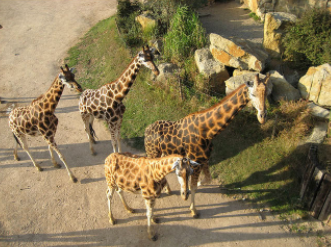



 Model prediction
<start> a group of giraffes standing next to each other . <end>


In [ ]:
img_path = "/content/gdrive/MyDrive/Colab/image-captioning/pytorch-tutorial/tutorials/03-advanced/image_captioning/png/example.png"
os.chdir('/content/gdrive/MyDrive/Colab/image-captioning/pytorch-tutorial/tutorials/03-advanced/image_captioning/')
with Image.open(img_path) as im:
    display(im)

print('\n\n Model prediction')

!python sample.py --image='png/example.png'